In [ ]:
# testing purposes: restrict to small subset of city

In [4]:
G = nx.read_gpickle('data_osm_raw/manila_clean.pickle')

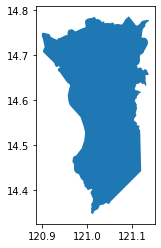

In [76]:
#get administrative boundary of metro manila
philippines_adm2 = gpd.read_file("boundaries/philippines_adm2.geojson")
philippines_adm2 = philippines_adm2.to_crs({'init':'epsg:4326'})
manila = philippines_adm2[philippines_adm2.ADM2_NAME=="Metropolitan Manila"]
manila_geom = manila.geometry.unary_union
manila.plot()

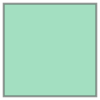

In [104]:
from shapely.geometry import box, polygon, multipolygon
import shapely.geometry
from shapely.ops import linemerge, unary_union, transform
import shapely
from functools import partial
import pyproj
box = box(121.05, 14.65, 121.1, 14.7)
box

In [105]:
def clip_new(G, bound, source_crs = 'epsg:4326', target_crs = 'epsg:4326', geom_col = 'geometry', largest_G = True):
    """
    Removes any edges that fall beyond a polygon, and shortens any other edges that do so
    :param G: a graph object.
    :param bound: a shapely polygon object
    :param source_crs: crs object in format 'epsg:4326'
    :param target_crs: crs object in format 'epsg:4326'
    :param geom_col: label name for geometry object
    :param largest_G: if True, takes largest remaining subgraph of G as G
    """

    edges_to_add, nodes_to_add = [],[]
    edges_to_remove, nodes_to_remove = [],[]

    if type(bound) == shapely.geometry.multipolygon.MultiPolygon or type(bound) == shapely.geometry.polygon.Polygon:
        pass
    else:
        raise ValueError('Bound input must be a Shapely Polygon or MultiPolygon object!')

    if type(G) != nx.classes.multidigraph.MultiDiGraph:
        raise ValueError('Graph object must be of type nx.classes.multidigraph.MultiDiGraph!')

    project_WGS_UTM = partial(
        pyproj.transform,
        pyproj.Proj(init=source_crs),
        pyproj.Proj(init=target_crs))

    G_copy = G.copy()
    print('pre_clip | nodes: %s | edges: %s' % (G_copy.number_of_nodes(), G_copy.number_of_edges()))

    existing_legitimate_point_geometries = {}
    for u, data in G_copy.nodes(data = True):
        geo_point = Point(round(data['x'],10),round(data['y'],10))
        if bound.contains(geo_point):
            existing_legitimate_point_geometries[u] = geo_point
        else:
            nodes_to_remove.append(u)

    iterator = 0
    done_edges = []

    for u, v, data in G_copy.edges(data = True):

        done_edges.append((v,u))

        if (u,v) in done_edges:
            pass

        else:
            # define basics from data dictionary
            infra_type = data['infra_type']
            #extract the geometry of the geom_col, if there is no explicit geometry, load the wkt
            try:
                geom = data[geom_col]
            except:
                geom = loads(data['Wkt'])

            # road fully within country - do nothing
            if bound.contains(geom) == True:
                pass

            # road fully outside country - remove entirely
            elif bound.intersects(geom) == False:

                edges_to_remove.append((u, v))
                edges_to_remove.append((v, u))
                nodes_to_remove.append(u)
                nodes_to_remove.append(v)

            # road partially in, partially out
            else:

                # start by removing existing edges
                edges_to_remove.append((u, v))
                edges_to_remove.append((v, u))

                # identify the new line sections inside the boundary
                new_geom = bound.intersection(geom)
                if type(new_geom) == shapely.geometry.multilinestring.MultiLineString:
                    new_geom = linemerge(new_geom)

                # If there is only one:
                if type(new_geom) == shapely.geometry.linestring.LineString:

                    new_nodes, new_edges, new_node_dict_entries, iterator = new_edge_generator(new_geom,infra_type,iterator,existing_legitimate_point_geometries,geom_col,project_WGS_UTM)
                    existing_legitimate_point_geometries.update(new_node_dict_entries)
                    nodes_to_add.append(new_nodes)
                    edges_to_add.append(new_edges)

                elif type(new_geom) == shapely.geometry.multilinestring.MultiLineString:

                    for n in new_geom:
                        new_nodes, new_edges, new_node_dict_entries, iterator = new_edge_generator(n,infra_type,iterator,existing_legitimate_point_geometries,geom_col, project_WGS_UTM)
                        existing_legitimate_point_geometries.update(new_node_dict_entries)
                        nodes_to_add.append(new_nodes)
                        edges_to_add.append(new_edges)

    # Remove bad geometries
    G_copy.remove_nodes_from(nodes_to_remove)
    G_copy.remove_edges_from(edges_to_remove)

    # Add new geometries
    nodes_to_add = [item for sublist in nodes_to_add for item in sublist]
    edges_to_add = [item for sublist in edges_to_add for item in sublist]
    G_copy.add_nodes_from(nodes_to_add)
    G_copy.add_edges_from(edges_to_add)

    # Re-label nodes
    G_copy = nx.convert_node_labels_to_integers(G_copy)
    print('post_clip | nodes: %s | edges: %s' % (G_copy.number_of_nodes(), G_copy.number_of_edges()))

    # Select only largest remaining graph
    if largest_G == True:
        list_of_Gs = list((nx.strongly_connected_component_subgraphs(G_copy)))
        list_length = list(len(i) for i in list_of_Gs)
        m = max(list_length)
        t = [i for i, j in enumerate(list_length) if j == m][0]
        max_G = list_of_Gs[t]
        G_copy = max_G

    return G_copy

def new_edge_generator(passed_geom, infra_type, iterator, existing_legitimate_point_geometries, geom_col, project_WGS_UTM):
    """
    Generates new edge and node geometries based on a passed geometry. WARNING: This is a child process of clip(), and shouldn't be run on its own
    :param passed_geom: a shapely Linestring object
    :param infra_type: the road / highway class of the passed geometry
    :param iterator: helps count the new node IDs to keep unique nodes
    :param existing_legitimate_point_geometries: a dictionary of points already created / valid in [u:geom] format
    :param project_WGS_UTM: projection object to transform passed geometries
    :param geom_col: label name for geometry object
    """

    edges_to_add = []
    nodes_to_add = []

    # new start and end points will be start and end of line
    u_geo = passed_geom.coords[0]
    v_geo = passed_geom.coords[-1]
    u_geom, v_geom = Point(round(u_geo[0],10),round(u_geo[1],10)), Point(round(v_geo[0],10),round(v_geo[1],10))

    # check to see if geometry already exists. If yes, assign u and v node IDs accordingly
    # else, make a new u and v ID
    if u_geom in existing_legitimate_point_geometries.values():
        u = list(existing_legitimate_point_geometries.keys())[list(existing_legitimate_point_geometries.values()).index(u_geom)]

    else:
        u = 'new_node_%s' % iterator
        node_data = {}
        node_data['x'] = u_geom.x
        node_data['y'] = u_geom.y
        nodes_to_add.append((u,node_data))
        iterator += 1

    if v_geom in existing_legitimate_point_geometries.values():
        v = list(existing_legitimate_point_geometries.keys())[list(existing_legitimate_point_geometries.values()).index(v_geom)]

    else:
        v = 'new_node_%s' % iterator
        node_data = {}
        node_data['x'] = v_geom.x
        node_data['y'] = v_geom.y
        nodes_to_add.append((v,node_data))
        iterator += 1

    # update the data dicionary for the new geometry
    UTM_geom = transform(project_WGS_UTM, passed_geom)
    edge_data = {}
    edge_data[geom_col] = passed_geom
    edge_data['length'] = UTM_geom.length / 1000
    edge_data['infra_type'] = infra_type

    # assign new edges to network
    edges_to_add.append((u, v, edge_data))
    edges_to_add.append((v, u, edge_data))

    # new node dict entries - add newly created geometries to library of valid nodes
    new_node_dict_entries = []

    for u, data in nodes_to_add:
        new_node_dict_entries.append((u,Point(round(data['x'],10),round(data['y'],10))))

    return nodes_to_add, edges_to_add, new_node_dict_entries, iterator

In [106]:
G_clip = clip_new(G, box, source_crs = 'epsg:4326', target_crs = 'epsg:4326', geom_col = 'geometry', largest_G = True)

pre_clip | nodes: 89758 | edges: 247696
post_clip | nodes: 5603 | edges: 14730


AttributeError: module 'networkx' has no attribute 'strongly_connected_component_subgraphs'

In [ ]:
G_clip.graph.update( {'crs' : crs_global} )
G_clip.graph.update( {'name' : 'manila'} )
ox.plot_graph(G_clip, fig_height=10, axis_off=False)

In [ ]:
gn.save(G_clip,'manila_clean_clipped','data_osm_raw')

In [ ]:
#import destination matrix

## import hazard data and plot, check

In [1]:
import geopandas as gpd
import pandas as pd
import GOSTnets as gn
import networkx as nx
import osmnx as ox

In [6]:
#https://epsg.io/3123
crs_manila = {'init': 'epsg:3123'}
crs_global = {'init': 'epsg:4326'}

In [2]:
cd /home/op/network_manila

/home/op/network_manila


In [8]:
#import hazard data

liquefaction = gpd.read_file(r"hazard_data/Liquefaction/Liquefaction_MetroManila.shp")
faultline = gpd.read_file(r"hazard_data/ActiveFault/ActiveFault_MetroManila.shp")

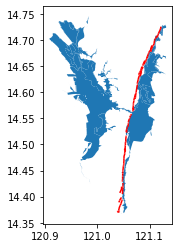

In [9]:
base=liquefaction.plot()
faultline.plot(ax=base, color='red')

In [15]:
liquefaction.crs, faultline.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'})

In [22]:
#import asset data

schools = gpd.read_file(r"asset_data/MetroManila/MetroManila/DepEd/SchoolLocation.shp")
hospitals = gpd.read_file(r"asset_data/MetroManila/MetroManila/DOH/HealthFacilities.shp")

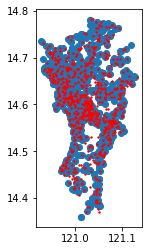

In [30]:
base=schools.plot()
hospitals.plot(ax=base, color='red', markersize=2)

In [24]:
len(schools), len(hospitals)

(768, 734)

In [25]:
schools.crs, hospitals.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'})

In [10]:
G.graph.update( {'crs' : crs_global} )
G.graph.update( {'name' : 'manila'} )

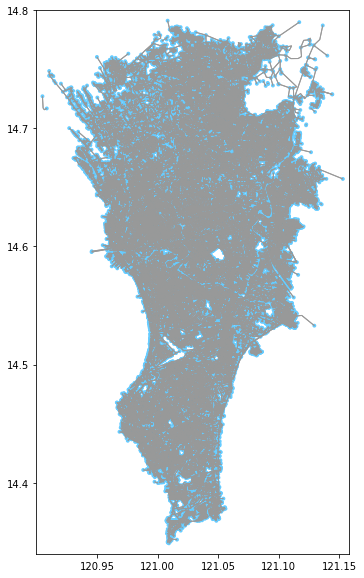

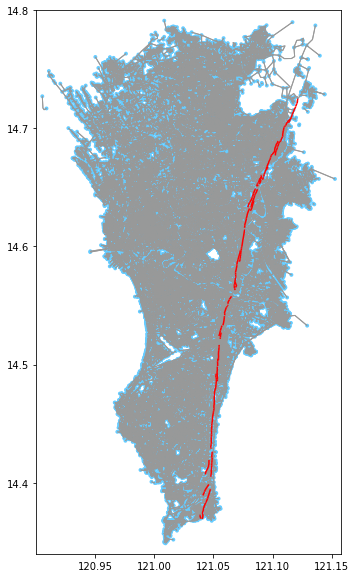

<Figure size 432x288 with 0 Axes>

In [36]:
fig, ax = ox.plot_graph(G, fig_height=10, axis_off=False)
faultline.plot(ax=ax, color='red')
#hospitals.plot(ax=ax, color='yellow', markersize=20, )
fig

## disrupt network with hazard data

In [51]:
import shapely
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Point

In [49]:
gdf_geometry = liquefaction.unary_union

In [60]:
list_of_nodes = {}
for u, data in G.nodes(data=True):
    list_of_nodes.update({u:(data['x'], data['y'])})


In [62]:
len(list_of_nodes), type(list_of_nodes)

(500, dict)

In [61]:
import itertools
list_of_nodes = dict(itertools.islice(list_of_nodes.items(), 500))

In [70]:
selKeys = []
selPts = []

for key, pt in list_of_nodes.items():
    if Point(pt[0], pt[1]).intersects(gdf_geometry):
        selPts.append(1)
        selKeys.append(key)


In [71]:
len(selKeys), len(selPts)

(155, 155)

In [73]:
def sample_gdf(G, gdf, property_name = 'intersects_gdf'):
    """
    :param G: a graph containing one or more nodes
    :param gdf: agdf
    :param property_name: a property name for whether the node intersects the gdf
    :returns: a graph
    """

    if type(G) == nx.classes.multidigraph.MultiDiGraph or type(G) == nx.classes.digraph.DiGraph:
        pass
    else:
        raise ValueError('Expecting a graph or geodataframe for G!')

    # generate dictionary of {node ID: point} pairs
    try:
        list_of_nodes = {}
        for u, data in G.nodes(data=True):
            list_of_nodes.update({u:(data['x'], data['y'])})
    except:
        raise ValueError('loading point geometry went wrong. Ensure node data dict includes x, y values!')

    # get gdf geometry
    try:
        gdf_geometry = gdf.unary_union
    except:
        raise ValueError('Expecting a geodataframe!')

    # create list of values, throw out nodes that don't intersect the bounds of the raster
    selKeys = []
    selPts = []
    for key, pt in list_of_nodes.items():
        if Point(pt[0], pt[1]).intersects(gdf_geometry):
            selPts.append(1)
            selKeys.append(key)

    # generate new dictionary of {node ID: 1 where 1 signals intersection}
    ref = dict(zip(selKeys, selPts))

    # load new values onto node data dictionary
    missedCnt = 0
    for u, data in G.nodes(data=True):
        try:
            data[property_name] = ref[u]
        except:
            missedCnt += 1
            logging.info("Could not add raster value to node %s" % u)
    logging.info("Number of original nodes: %s" % len(G.nodes))
    logging.info("Number of missed nodes in raster: %d" % missedCnt)
    logging.info("Number of nodes that intersected raster: %d" % len(selKeys))

    return G

In [75]:
G_liq = sample_gdf(G, liquefaction, property_name = 'intersects_gdf')


NameError: name 'dataset' is not defined

In [ ]:
nc = ox.get_node_colors_by_attr(G_liq, 'intersects_gdf', cmap='plasma', num_bins=2)
fig, ax = ox.plot_graph(G_liq, fig_height=6, node_color=nc, node_size=12, node_zorder=2, edge_color='#dddddd')

In [ ]:
values = list

In [69]:
ref = dict(zip(selKeys, int(1)))


TypeError: zip argument #2 must support iteration

In [ ]:
def sample_raster(G, tif_path, property_name = 'RasterValue'):
    """
    Function for attaching raster values to corresponding graph nodes. Ensure any GeoDataFrames / graphs are in the same projection before using function, or pass a crs
    :param G: a graph containing one or more nodes
    :param tif_path: a raster or path to a tif
    :param property_name: a property name for the value of the raster attached to the node
    :returns: a graph
    """

    import rasterio

    if type(G) == nx.classes.multidigraph.MultiDiGraph or type(G) == nx.classes.digraph.DiGraph:
        pass
    else:
        raise ValueError('Expecting a graph or geodataframe for G!')

    # generate dictionary of {node ID: point} pairs
    try:
        list_of_nodes = {}
        for u, data in G.nodes(data=True):
            list_of_nodes.update({u:(data['x'], data['y'])})
    except:
        raise ValueError('loading point geometry went wrong. Ensure node data dict includes x, y values!')

    # load raster
    try:
        dataset = rasterio.open(os.path.join(tif_path))
    except:
        raise ValueError('Expecting a path to a .tif file!')

    # create list of values, throw out nodes that don't intersect the bounds of the raster
    b = dataset.bounds
    datasetBoundary = box(b[0], b[1], b[2], b[3])
    selKeys = []
    selPts = []
    for key, pt in list_of_nodes.items():
        if Point(pt[0], pt[1]).intersects(datasetBoundary):
            selPts.append(pt)
            selKeys.append(key)
    raster_values = list(dataset.sample(selPts))
    raster_values = [x[0] for x in raster_values]

    # generate new dictionary of {node ID: raster values}
    ref = dict(zip(selKeys, raster_values))

    # load new values onto node data dictionary
    missedCnt = 0
    for u, data in G.nodes(data=True):
        try:
            data[property_name] = ref[u]
        except:
            missedCnt += 1
            logging.info("Could not add raster value to node %s" % u)
    logging.info("Number of original nodes: %s" % len(G.nodes))
    logging.info("Number of missed nodes in raster: %d" % missedCnt)
    logging.info("Number of nodes that intersected raster: %d" % len(selKeys))

    return G

disruption in GN is working based on whether nodes are in field of disaster -
this is bad if long edges without nodes lead through disaster fields, as these will not be affected. 
one solution to this is the salt long lines option


for ground liquefaction we want to slow everything down - could use approach similar to this: 
    https://github.com/worldbank/GOST_PublicGoods/blob/master/Implementations/SierraLeone%20-%20GOSTnets/Step%204.a%20-%20Generate%20Flooding%20Version%20of%20Graph.ipynb

In [ ]:
def graph_edges_intersecting_polygon(G, polygons, mode, crs = None, fast = True):
    """
    Function for identifying edges of a graph that intersect polygon(s). Ensure any GeoDataFrames are in the same projection before using function, or pass a crs.

In [ ]:

def disrupt_network(G, property, thresh, fail_value):
    """
    Function for disrupting a graph given a threshold value against a node's value. Any edges which bind to broken nodes have their 'time' property set to fail_value


In [ ]:
def graph_edges_intersecting_polygon(G, polygons, mode, crs = None, fast = True):
    """
    Function for identifying edges of a graph that intersect polygon(s). Ensure any GeoDataFrames are in the same projection before using function, or pass a crs.

## od matrices

In [ ]:
project graph
convert to time

In [39]:
gn.example_node(G)

(0, {'x': 121.032836, 'y': 14.566063})


In [40]:
gn.example_edge(G)

(0, 19650, {'Wkt': 'LINESTRING (121.032836 14.566063, 121.033509 14.5655514)', 'id': 18962, 'infra_type': 'residential', 'osm_id': '23006710', 'key': 'edge_18962', 'length': 0.0920008330049905, 'Type': 'legitimate'})


In [ ]:
disruptio